In [1]:
import pyedflib
import numpy as np
import pandas as pd

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
%matplotlib inline

В качестве примера здесь будет использована одна запись из указаного датасета.

In [2]:
file_name = "./data/chb01_03.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

Пример разбора одного пациента, указание параметров

In [3]:
sr = 256
batch_size = 64
preictal_time = 20 * 60 * sr

siez_starts = [2996, 1467, 1732, 1015, 1720, 327, 1862]
siez_starts = [siez_starts[i] * sr for i in range(len(siez_starts))]
siez_ends = [3036, 1494, 1772, 1066, 1810, 420, 1963]
siez_ends = [siez_ends[i] * sr for i in range(len(siez_ends))]
file_names = ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf", "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"]

Разбивка данных на тренировочные и тестовые

In [4]:
data = sigbufs
data = gaussian_filter(data, sigma=3, radius=5)
lstm_train = data[:, :400000]
lstm_test =  data[:, 400000:500000]

mean = lstm_train.mean(axis=1)
std = lstm_train.std(axis=1)

train_norm = (lstm_train - mean[..., None])/std[..., None]
test_norm = (lstm_test - mean[..., None])/std[..., None]

train_norm = torch.FloatTensor(train_norm)
test_norm = torch.FloatTensor(test_norm)

Модель LSTM

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, 
                            bias=False, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size, bias=False)
        

    def whole_seq_forward(self, x):
        batchsize = x.shape[0]
        
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        print("lstm size", lstm_out.size())
    
        predictions = self.linear_2(lstm_out)
        
        return predictions
        
        
        
    def forward(self, x):
        batchsize = x.shape[0]
        
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)     
        
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        

        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 

        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        
        return predictions

Формирование датасета для подачи в обучение

In [6]:
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = input_data.shape[-1]
    for i in range(L-tw):
        train_seq = input_data[:, i:i+tw]
        train_label = input_data[:, i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

Функция прогона одной эпохи

In [7]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
         
        x = x.transpose(1, 2).to('cuda')
        y = y[:, :, -1].to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

Функция тренировки с сохранением модели

In [8]:
def train(model_lstm, exp_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
    scheduler = ReduceLROnPlateau(optimizer, patience = 8, factor=0.5, min_lr=0.0001)
    lr = 0.001
    epochs = 175

    losses_train = []
    losses_test = []
    best_loss = 10e9
    # begin training
    
    early_stop_count = 15
    current_es = 0
    for epoch in range(epochs): 
        loss_train = run_epoch(model_lstm, optimizer, criterion, train_dataloader, is_training=True)
        loss_val = run_epoch(model_lstm, optimizer, criterion, test_dataloader)
        scheduler.step(loss_val)
        losses_train.append(loss_train)
        losses_test.append(loss_val)

        if losses_test[-1] < best_loss:
            current_es = 0
            best_loss = losses_test[-1]
            torch.save(model_lstm.state_dict(), "./models/LSTMChildrenSeveralLeads" + exp_name)
        else:
            current_es += 1
        if current_es == early_stop_count:
            break

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)
        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)
        plt.show()
    
        
        print(exp_name)
        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, epochs, loss_train, loss_val))

Прогон экспериментов (сейчас выбраны параметры для мемристивной сети)

In [ ]:
hiddens = [5]
n_layers = [1]
dropout = [0]

params = [(h, l, dr) for h in hiddens for l in n_layers for dr in dropout]

for n_hidden, n_layers, dropout in tqdm(params):
    exp_name = "_5_hidden_test"
    model = LSTMModel(input_size=23, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=23, dropout=dropout)
    model = model.to('cuda')
    train(model, exp_name)

Функция для вычисления предсказаний и метрики RMSE для них

In [8]:
def GetRmse(model, val_dataloader, lstm_test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test[0])- 20)%64
        predicted_val = np.zeros((1, 23))
        for idx, (x, y) in enumerate(val_dataloader):
            x = x.transpose(1, 2).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #print(out.shape)
                #print(cur_x.shape)
                cur_x = torch.hstack((cur_x[:, 1:, :], out[..., None].transpose(1, 2)))
                #print(cur_x.shape)
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, :].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val[1:])*std[None, ...]+mean[None, ...])
        if k == 1:
            
            r = ((((np.array(predicted_val)*std[None, ...]+mean[None, ...])[1:, 0] - np.array(lstm_test[0, 20:-test_right_part]))**2).mean())**0.5
        else:
            r = ((((np.array(predicted_val[:-k+1])*std[None, ...]+mean[None, ...])[1:, 0] - np.array(lstm_test[0, 20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, np.array(lstm_predicts)

Загрузка обученной модели

In [17]:
model = LSTMModel(input_size=23, hidden_layer_size=5, num_layers=1, output_size=23, dropout=0)
model.load_state_dict(torch.load("./models/LSTMChildrenSeveralLeads" + "_5_hidden_test"))
model.to("cuda")

LSTMModel(
  (linear_1): Linear(in_features=23, out_features=5, bias=False)
  (relu): ReLU()
  (lstm): LSTM(5, 5, bias=False, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear_2): Linear(in_features=5, out_features=23, bias=False)
)

Прогон всей последовательности через модель без зануления скрытого состояния для горизонта предсказания 1

In [ ]:
model.eval()

x = torch.FloatTensor(test_norm).T[None, ...]
        
out = model.whole_seq_forward(x.to('cuda'))
        

Перевод от нормированных данных к исходным

In [37]:
preds = out.cpu().detach().numpy()
preds = preds *std[None, ...]+mean[None, ...]

Отрисовка части одного отведения

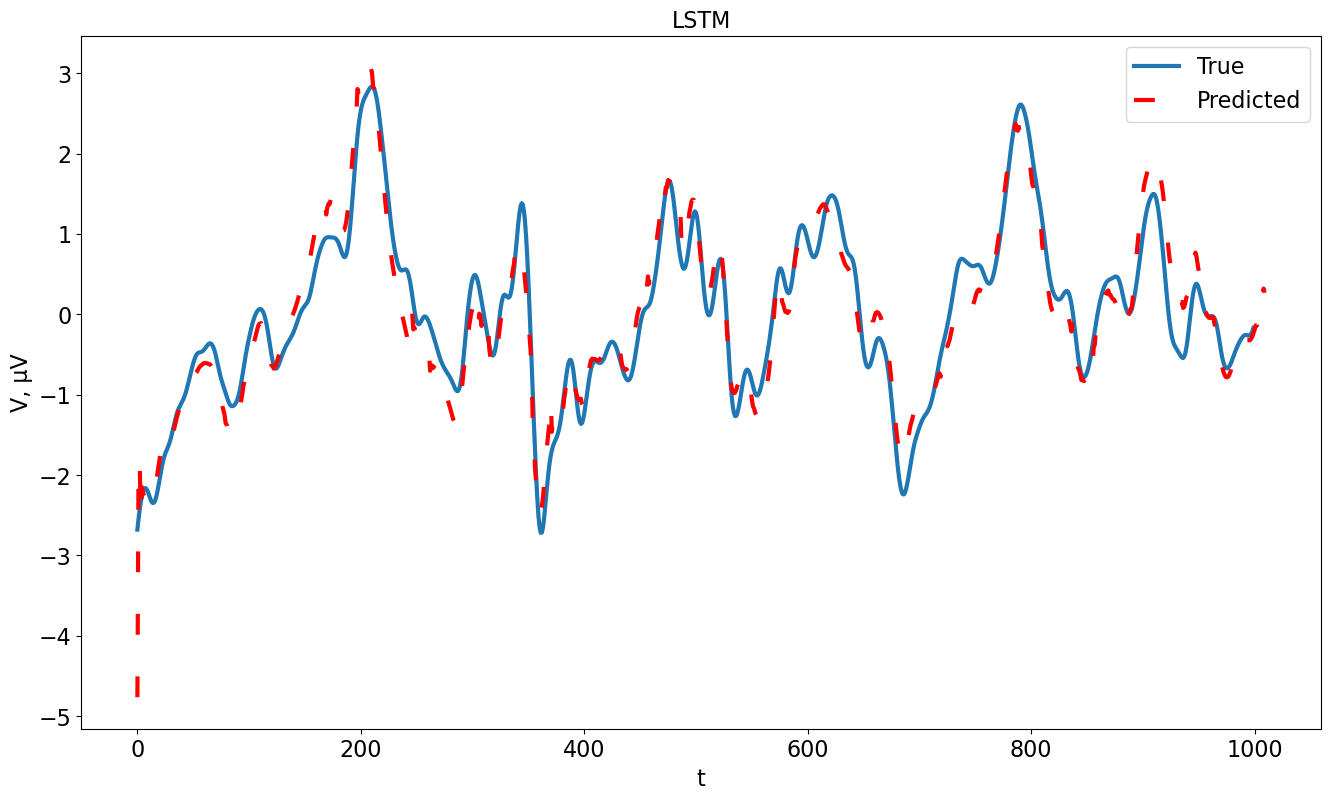

In [43]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(test_norm[0, 10: 1000], linewidth = 3, label='True')
ax.plot(preds[0][10:1010, 0],  linestyle = (0, (5, 10)), linewidth = 3, label='Predicted', color="red")
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
ax.set_xlabel("t",  fontsize = 16)
ax.set_ylabel("V, µV",  fontsize = 16)
ax.set_title('LSTM',  fontsize = 16)

plt.show()

Полная отрисовка одного отведения

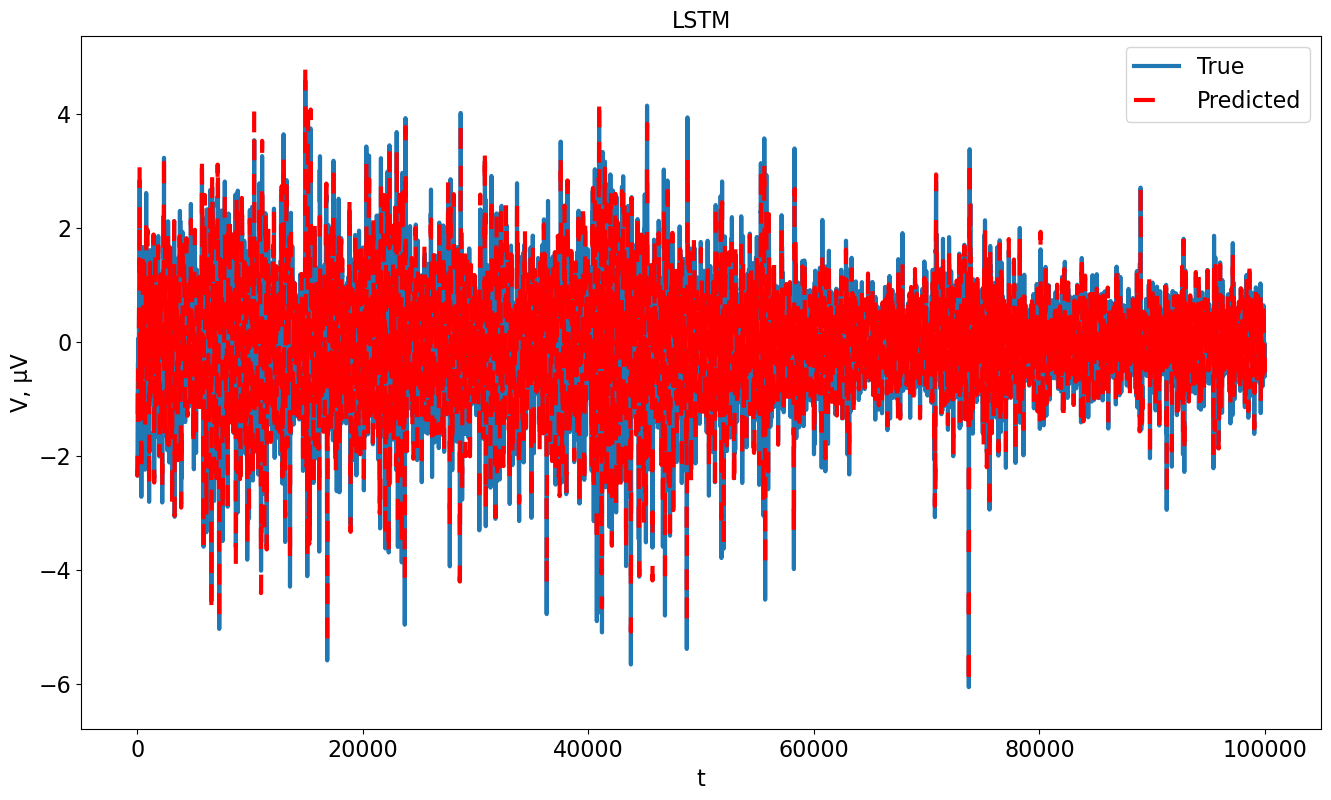

In [39]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(test_norm[0, 11: ], linewidth = 3, label='True')
ax.plot(preds[0][10:-1, 0],  linestyle = (0, (5, 10)), linewidth = 3, label='Predicted', color="red")
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
ax.set_xlabel("t",  fontsize = 16)
ax.set_ylabel("V, µV",  fontsize = 16)
ax.set_title('LSTM',  fontsize = 16)

plt.show()

Расчет предсказаний для горизонта предсказания 20, подсчет метрики.

In [11]:
rmse,lstm_predicts = GetRmse(model, test_dataloader, lstm_test, std, mean)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [03:27<00:00, 10.90s/it]


Функция отрисовки части одного отведения для горизонта предсказания k.

In [26]:
def Plt(k):

    
    fig, ax = plt.subplots(figsize = (16, 9))
    ax.plot(lstm_test[0, 10+k-1: 10+k-1 + 1000], linewidth = 3, label='True')
    ax.plot(lstm_predicts[k-1][:1000, 0],  linestyle = (0, (5, 10)), linewidth = 3, label='Predicted', color="red")
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_xlabel("t",  fontsize = 16)
    ax.set_ylabel("V, µV",  fontsize = 16)
    ax.set_title('LSTM',  fontsize = 16)
    
    plt.show()
    

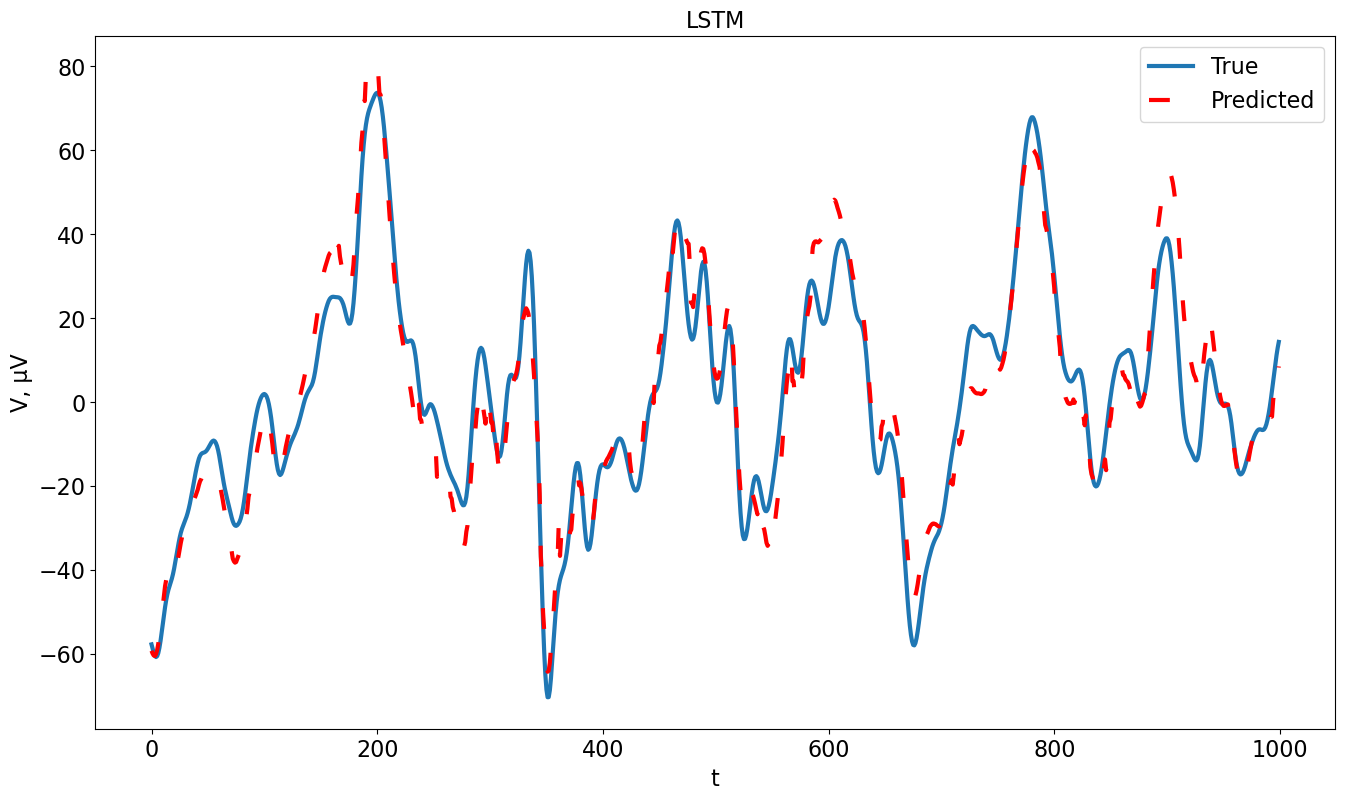

In [27]:
Plt(1)

Сохранение весов, входов и выходов для моделирования сети в SimuLink

In [42]:
col_namesx = []
col_namesy = []
for i in range(1000):
    col_namesx.append("x" + str(i))
    col_namesy.append("y" + str(i))
    

df = pd.DataFrame(test_norm[:, 0:1000], columns=col_namesx)
df.to_csv("x1000.csv", decimal=',')
df = pd.DataFrame(preds[0][0:1000, :].T, columns=col_namesy)
df.to_csv("y1000.csv", decimal=',')    

In [14]:
k = 1
for i in range(5):
    df = pd.DataFrame(lstm_test[:, i: i + 10])
    df.to_csv("x" + str(i) + ".csv", decimal=',')
    df = pd.DataFrame(lstm_predicts[k-1][i, :])
    df.to_csv("y" + str(i) + ".csv", decimal=',')    

In [34]:
model = LSTMModel(input_size=23, hidden_layer_size=5, num_layers=1, output_size=23, dropout=0)
model.load_state_dict(torch.load("./models/LSTMChildrenSeveralLeads" + "_5_hidden_test"))

<All keys matched successfully>

In [46]:
df = pd.DataFrame(model.linear_1.weight.detach().T)
df.to_csv("weights/W_in.csv", decimal=',')

In [47]:
df = pd.DataFrame(model.linear_2.weight.detach())
df.to_csv("weights/W_out.csv", decimal=',')

In [55]:
df = pd.DataFrame(model.lstm.weight_ih_l0.detach())
df.to_csv("weights/Wx.csv", decimal=',')

In [56]:
df = pd.DataFrame(model.lstm.weight_hh_l0.detach())
df.to_csv("weights/Wh.csv", decimal=',')